In [2]:
# Giorgio Angelotti - 2024
# noteboook greatly inspired from https://github.com/facebookresearch/segment-anything-2/blob/778e1127404547429b281d9c9394ddb3652b85a5/notebooks/video_predictor_example.ipynb

import numpy as np
import torch
import cv2
import nrrd
import os
from pathlib import Path
from PIL import Image
from sam2.build_sam import build_sam2_video_predictor
from matplotlib import pyplot as plt

# use bfloat16 for the entire script (memory efficient)
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

def read_image(volume_file, mask_file): # read and resize image and mask
        volume, _ = nrrd.read(volume_file)
        masks, _ = nrrd.read(mask_file)
        
        # Create the directory if it doesn't exist
        output_dir = "test_img"
        os.makedirs(output_dir, exist_ok=True)

        for z_slice in range(volume.shape[0]):
                img = volume[z_slice]
                mask = masks[z_slice]
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
                r = np.min([1024 / img.shape[1], 1024 / img.shape[0]])
                img = cv2.resize(img, (int(img.shape[1] * r), int(img.shape[0] * r)))
                mask = cv2.resize(mask, (int(mask.shape[1] * r), int(mask.shape[0] * r)),interpolation=cv2.INTER_NEAREST)

                #unique_labels = np.unique(mask)[1:]

                #idx = np.random.randint(0, unique_labels.shape[0])
                #lbl = (mask == unique_labels[idx]).astype(np.uint8)

                # Save the image and mask
                img_filename = os.path.join(output_dir, f"{z_slice:03d}.jpg")
                #lbl_filename = os.path.join(output_dir, f"{z_slice:03d}_mask.jpg")
                cv2.imwrite(img_filename, img)
                #cv2.imwrite(lbl_filename, mask)  # Multiply by 255 to save the binary mask as an image

        return volume, masks


In [ ]:
# Load model you need to have pretrained model already made
sam2_checkpoint = "./checkpoints/sam2_hiera_large.pt" # "sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml" # "sam2_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint) 

predictor.load_state_dict(torch.load("model.torch")) # loads the checkpoint finetuned on the cubes

# Load image
cube_folder = Path("/your/custom/path/validation-cubes") # put your own folder

# List all directories in the specified path
directories = [f for f in cube_folder.iterdir() if f.is_dir()]

In [3]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab20")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

In [4]:
for idx in range(len(directories)):
    directory  = directories[idx]
    directory_name = directory.name 
    mask_file = directory / f"{directory_name}_mask.nrrd"
    volume_file = directory / f"{directory_name}_volume.nrrd"   
    # read image and sample points
    gt_volume,gt_mask = read_image(volume_file, mask_file)
    inference_state = predictor.init_state(video_path="./test_img")
    predictor.reset_state(inference_state)
    mask_ids = np.unique(gt_mask)[1:]
    ann_frames=[0,255]
    for ann_frame in ann_frames:
        for mask_id in mask_ids:    
            gt_mask_temp = np.copy(gt_mask)
            gt_mask_temp[gt_mask_temp != mask_id] = 0
            _, out_obj_ids, out_mask_logits = predictor.add_new_mask(inference_state=inference_state, frame_idx=ann_frame, obj_id=mask_id, mask=gt_mask_temp[ann_frame])
    # run propagation throughout the video and collect the results in a dict
    video_segments = {}  # video_segments contains the per-frame segmentation results
    for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
        video_segments[out_frame_idx] = {
            out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
            for i, out_obj_id in enumerate(out_obj_ids)
        }

    mask = np.zeros((256,256,256), dtype=np.uint8)
    for i in range(len(video_segments)):
        for k in video_segments[i].keys():
            mask[i] += cv2.resize(video_segments[i][k][0].astype(np.uint8)*k, (256, 256))

    coordinates = directory_name.split("_")
    for i in range(len(coordinates)):
        coordinates[i] = int(coordinates[i])

    mask_newfile = directory / f"{directory_name}_sam2.nrrd"

    header = {}
    space_origin = np.array([coordinates[0], coordinates[1], coordinates[2]], dtype=np.float64)
    header['space origin'] = space_origin
    header['type'] = 'uint8'
    header['dimension'] = 3
    header['endian'] = 'little'
    header['space directions'] = np.array([
                                            [1, 0, 0],
                                            [0, 1, 0],
                                            [0, 0, 1]
                                        ], dtype=np.float64)
                                        
                            # Setting the space attribute
    header['space'] = 'left-posterior-superior'

    nrrd.write(file=str(mask_newfile), data=mask, header=header, compression_level=1)
    


frame loading (JPEG): 100%|██████████| 256/256 [00:01<00:00, 134.64it/s]
/home/giorgio/Projects/sam2/sam2/sam2_video_predictor.py:869: UserWarning: /home/giorgio/Projects/sam2/sam2/_C.so: undefined symbol: _ZN3c1015SmallVectorBaseIjE8grow_podEPKvmm

Skipping the post-processing step due to the error above. Consider building SAM 2 with CUDA extension to enable post-processing (see https://github.com/facebookresearch/segment-anything-2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(
propagate in video: 100%|██████████| 256/256 [00:44<00:00,  5.81it/s]


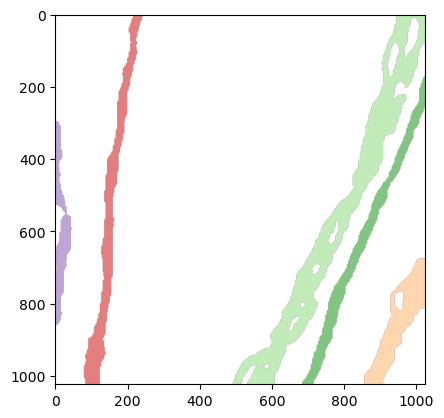

In [31]:
for i, out_obj_id in enumerate(out_obj_ids):
    show_mask((out_mask_logits[i] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_id)